In [70]:
from timeatlas import TimeSeries, models, detectors, metrics
import pandas as pd
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# Anomaly Detection on Artificial Data
---

## Paths

In [2]:
ROOT_PATH = "../data/households/"
DATASET_NAME = "household"
DATA_PATH = "/0/data.csv"
LABEL_SUFFIX = "_labels.csv"

TRAIN_SET = ROOT_PATH + DATASET_NAME + DATA_PATH

ANOMALOUS_SET = [
    ROOT_PATH + DATASET_NAME + "_change_point_data" + DATA_PATH, 
    ROOT_PATH + DATASET_NAME + "_clipping_data" + DATA_PATH, 
    ROOT_PATH + DATASET_NAME + "_electric_feedback_data" + DATA_PATH, 
    ROOT_PATH + DATASET_NAME + "_flatline_data" + DATA_PATH, 
    ROOT_PATH + DATASET_NAME + "_hard_knee_data" + DATA_PATH,
    ROOT_PATH + DATASET_NAME + "_increase_noise_data" + DATA_PATH,
    ROOT_PATH + DATASET_NAME + "_max_smoothing_data" + DATA_PATH,
    ROOT_PATH + DATASET_NAME + "_outlier_data" + DATA_PATH,
    ROOT_PATH + DATASET_NAME + "_ratio_compression_data" + DATA_PATH,
    ROOT_PATH + DATASET_NAME + "_trend_data" + DATA_PATH,
    ROOT_PATH + DATASET_NAME + "_zeroing_data" + DATA_PATH
]

ANOMALOUS_LABELS = [
    ROOT_PATH + DATASET_NAME + "_change_point_data" + "/" + DATASET_NAME + "_change_point_labels.csv",
    ROOT_PATH + DATASET_NAME + "_clipping_data" + "/" + DATASET_NAME + "_clipping_labels.csv",
    ROOT_PATH + DATASET_NAME + "_electric_feedback_data" + "/" + DATASET_NAME + "_electric_feedback_labels.csv",
    ROOT_PATH + DATASET_NAME + "_flatline_data" + "/" + DATASET_NAME + "_flatline_labels.csv",
    ROOT_PATH + DATASET_NAME + "_hard_knee_data" + "/" + DATASET_NAME + "_hard_knee_labels.csv",
    ROOT_PATH + DATASET_NAME + "_increase_noise_data" + "/" + DATASET_NAME + "_increase_noise_labels.csv",
    ROOT_PATH + DATASET_NAME + "_max_smoothing_data" + "/" + DATASET_NAME + "_max_smoothing_labels.csv",
    ROOT_PATH + DATASET_NAME + "_outlier_data" + "/" + DATASET_NAME + "_outlier_labels.csv",
    ROOT_PATH + DATASET_NAME + "_ratio_compression_data" + "/" + DATASET_NAME + "_ratio_compression_labels.csv",
    ROOT_PATH + DATASET_NAME + "_trend_data" + "/" + DATASET_NAME + "_trend_labels.csv",
    ROOT_PATH + DATASET_NAME + "_zeroing_data" + "/" + DATASET_NAME + "_zeroing_labels.csv",
]

## Data Loading

### Training Data

In [3]:
train = pd.read_csv(TRAIN_SET)
train.index = pd.to_datetime(train["index"])
train = train.drop(columns=["index"])
ts_train = TimeSeries(train["values"])
ts_train.series.head()

index
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: values, dtype: float64

### Anomalous Sets

Let's create some sets of time series with anomalies and their associated labels

#### with anomalies only

In [4]:
tsd_anomalous = []

for i in ANOMALOUS_SET:
    df = pd.read_csv(i)
    df.index = pd.to_datetime(df["index"])
    df = df.drop(columns=["index"])
    ts = TimeSeries(df["values"])
    tsd_anomalous.append(ts)

In [5]:
tsd_anomalous

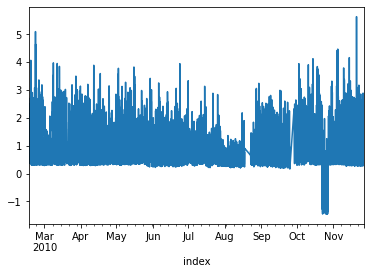

In [6]:
tsd_anomalous[0].series.astype(float).plot();

#### with anomalies and labels

In [7]:
tsd_anomalous_w_labels = []

for i, label_path in enumerate(ANOMALOUS_LABELS):
    
    # Load the anomalies positions
    label = pd.read_csv(label_path)
    anomalies_boundaries = label[["start","end"]].values

    # Load the anomalous time series
    data = pd.read_csv(ANOMALOUS_SET[i])

    # Add a time series of boolean representing the presence of anomaly for each time steps 
    data["labels"] = False
    for i in anomalies_boundaries:
        start = i[0]
        end = i[1]
        if start == end:
            data["labels"][start] = True
        else:
            data["labels"][start:end] = True
    
    # Add all this in a TimeSeries object
    data.index = pd.to_datetime(data["index"])
    data = data.drop(columns=["index"])
    ts = TimeSeries(data[["values", "labels"]])
    
    # Finish!
    tsd_anomalous_w_labels.append(ts)        
    

/Users/frederic.montet/.local/share/virtualenvs/timeatlas-6ip_oGBK/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/frederic.montet/.local/share/virtualenvs/timeatlas-6ip_oGBK/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
tsd_anomalous_w_labels

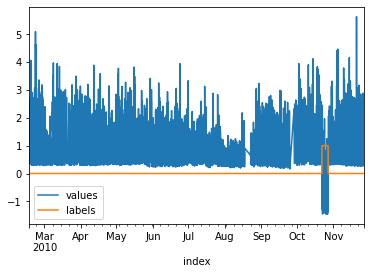

In [9]:
tsd_anomalous_w_labels[0].series.astype(float).plot();

### Modelling

#### Select shorter time window

In [10]:
ts_train.boundaries()

(Timestamp('2006-12-16 17:24:00'), Timestamp('2010-11-26 21:02:00'))

Knowing that allow us to say that a window of 3 years from 2007-01-01 to 2009-12-31 seems good for modelling

In [11]:
ts_train.series = ts_train.series["2007-01-01":"2009-12-31"]

#### Resampling

In [12]:
ts_train.series.head()

index
2007-01-01 00:00:00    2.580
2007-01-01 00:01:00    2.552
2007-01-01 00:02:00    2.550
2007-01-01 00:03:00    2.550
2007-01-01 00:04:00    2.554
Name: values, dtype: float64

At the moment, there is one data point per minute. For the purpose of modelling, we will take the average of the data point per hour. This will drastically reduce our model training time.

In [13]:
ts_train.series = ts_train.series.resample("1H").mean()

In [14]:
ts_train.series.head()

index
2007-01-01 00:00:00    2.550633
2007-01-01 01:00:00    2.523400
2007-01-01 02:00:00    2.582333
2007-01-01 03:00:00    2.541667
2007-01-01 04:00:00    2.475733
Freq: H, Name: values, dtype: float64

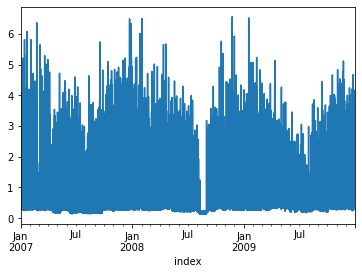

In [65]:
ts_train.plot()

#### Make a model

In [15]:
m = models.Prophet()

In [16]:
m.fit(ts_train)

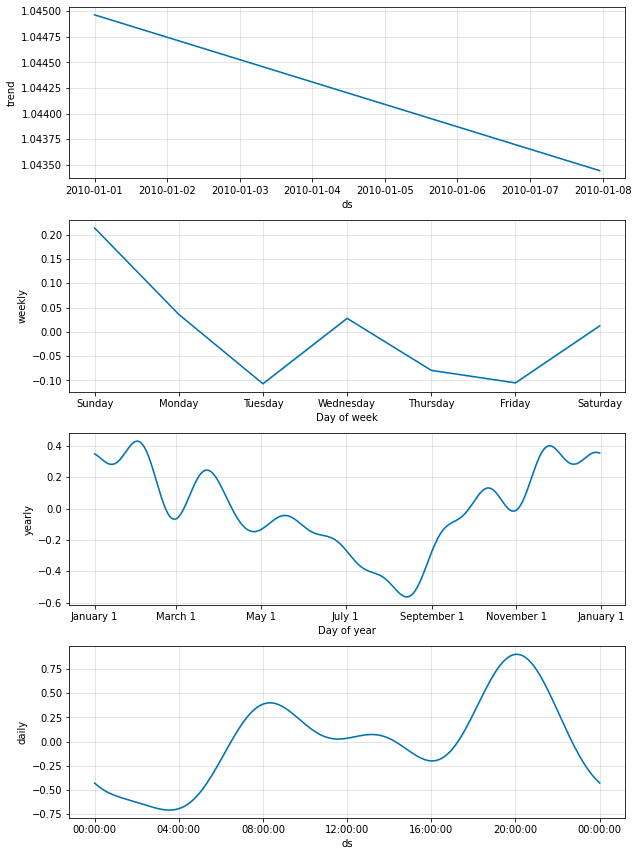

In [17]:
future = m.make_future_dataframe("7 days")
pred = m.model.predict(future)
m.model.plot_components(pred);

Now that the model is trained, let's briefly check it's validity by plotting it.

In [18]:
fcst = m.predict("7 days")

In [19]:
fcst.series.head()

ds
2010-01-01 00:00:00    0.860339
2010-01-01 01:00:00    0.730779
2010-01-01 02:00:00    0.665298
2010-01-01 03:00:00    0.603389
2010-01-01 04:00:00    0.604390
Name: values, dtype: float64

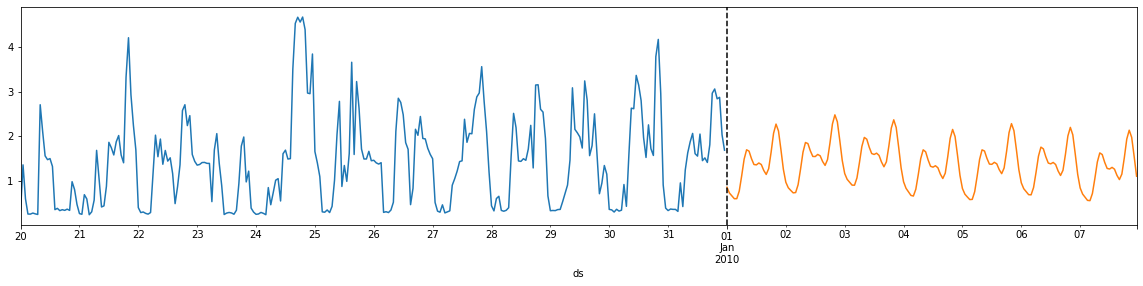

In [20]:
fig = plt.figure(figsize=(20,4))
ts_train["12-20-2009":].plot()
fcst.plot()
plt.axvline(x="2010-01-01", color='k', linestyle='--');

### Model Diagnostic

In [84]:
df_cv = cross_validation(m.model, initial='800 days', period='10 days', horizon = '30 days')
df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 27 forecasts with cutoffs between 2009-03-16 23:00:00 and 2009-12-01 23:00:00


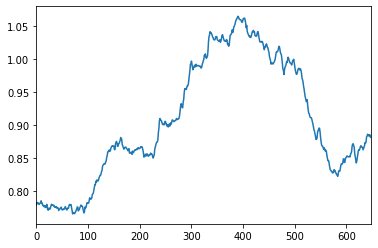

In [82]:
df_p["mape"].plot()

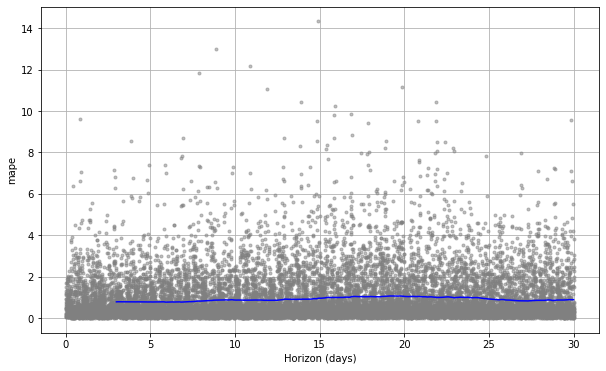

In [83]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Detect anomalies

In [174]:
tsd_detected_anomalies = tsd_anomalous_w_labels

thresholds = [
    [0.999],
    [0.999],
    [0.999],
    [0.999],
    [0.999],
    [0.999],
    [0.999],
    [0.999],
    [0.95],
    [0.95],
    [0.95]
]


In [175]:
# Create a detector
s = detectors.Surprise(m, metrics.relative_error)

for i, ts in enumerate(tsd_anomalous_w_labels):

    # Set the alerts
    s.alerts("quantile", thresholds[i])

    # Fit the detector to find the thresholds
    s.fit(ts_train)

    # Create an anomaly time series
    anomalies = s.detect(tsd_anomalous[i])

    # save it 
    tsd_detected_anomalies[i].series["detected_anomalies"] = anomalies.series

/Users/frederic.montet/.local/share/virtualenvs/timeatlas-6ip_oGBK/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/Users/frederic.montet/.local/share/virtualenvs/timeatlas-6ip_oGBK/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 432x288 with 0 Axes>

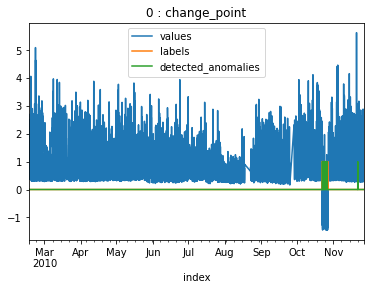

<Figure size 432x288 with 0 Axes>

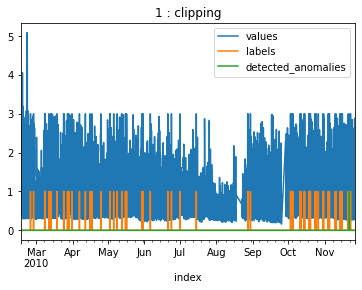

<Figure size 432x288 with 0 Axes>

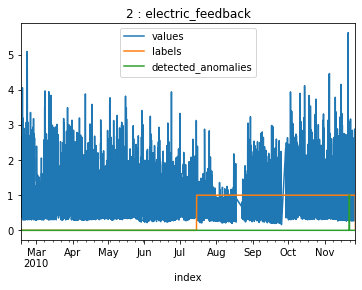

<Figure size 432x288 with 0 Axes>

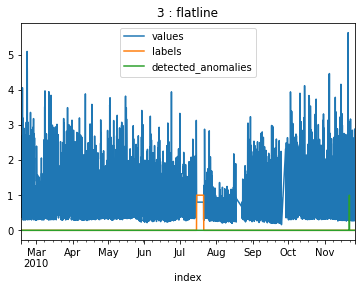

<Figure size 432x288 with 0 Axes>

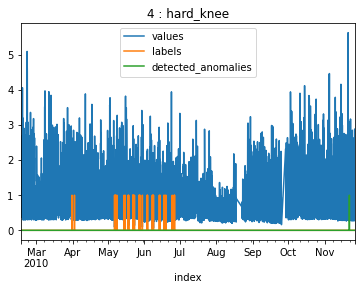

<Figure size 432x288 with 0 Axes>

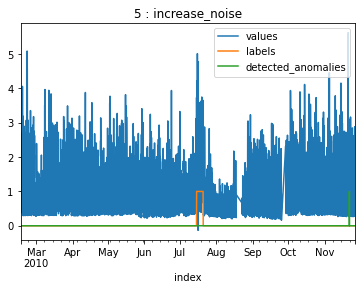

<Figure size 432x288 with 0 Axes>

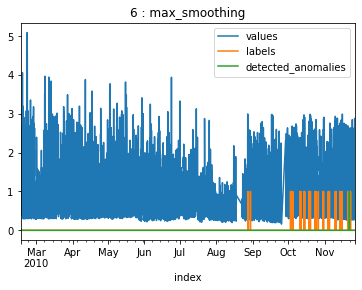

<Figure size 432x288 with 0 Axes>

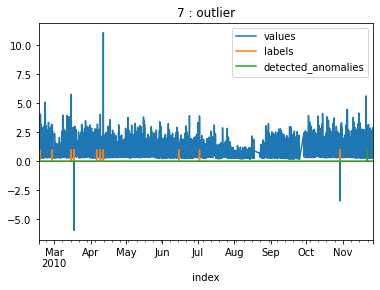

<Figure size 432x288 with 0 Axes>

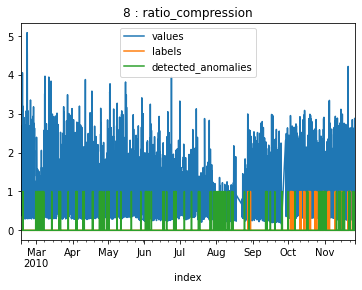

<Figure size 432x288 with 0 Axes>

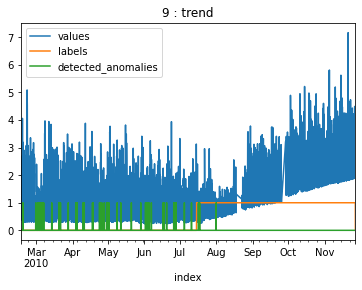

<Figure size 432x288 with 0 Axes>

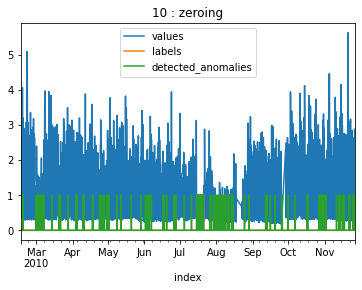

In [176]:
for i, ts in enumerate(tsd_detected_anomalies):
    
    anomaly_file_path = ANOMALOUS_LABELS[i]
    
    # Load the anomalies positions
    label = pd.read_csv(anomaly_file_path)
    anomaly_name = label["function_name"].values[0]
    
    fig = plt.figure()
    ts.series.astype(float).plot(title="{} : {}".format(i,anomaly_name));

## Performance Measurement

### On all samples

In [198]:
def find_tp(injected, detected):
    if injected == 1 and detected == 1:
        return 1
    else:
        return 0
    

In [199]:
def find_fp(injected, detected):
    if injected == 0 and detected == 1:
        return 1
    else:
        return 0    

In [200]:
def find_fn(injected, detected):
    if injected == 1 and detected == 0:
        return 1
    else: 
        return 0

In [201]:
scores = {}
for i, ts in enumerate(tsd_detected_anomalies):
    
    anomaly_file_path = ANOMALOUS_LABELS[i]
    
    # Load the anomalies positions
    label = pd.read_csv(anomaly_file_path)
    anomaly_name = label["function_name"].values[0]
    
    res = pd.DataFrame()
    res["tp"] = ts.series.astype(float).apply(lambda x : find_tp(x["labels"], x["detected_anomalies"]), axis=1) 
    res["fp"] = ts.series.astype(float).apply(lambda x : find_fp(x["labels"], x["detected_anomalies"]), axis=1) 
    res["fn"] = ts.series.astype(float).apply(lambda x : find_fn(x["labels"], x["detected_anomalies"]), axis=1)     
    
    res = res.astype(float).sum()
    
    precision = res["tp"] / (res["tp"] + res["fp"])
    recall = res["tp"] / (res["tp"] + res["fn"])
    f1 = 2 * (precision * recall) / (precision + recall)
    
    scores[anomaly_name] = {
        "precision": round(precision,2),
        "recall": round(recall,2),
        "f1": round(f1,2)
    }

/Users/frederic.montet/.local/share/virtualenvs/timeatlas-6ip_oGBK/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [202]:
scores

{'change_point': {'precision': 0.91, 'recall': 0.08, 'f1': 0.14},
 'clipping': {'precision': 0.0, 'recall': 0.0, 'f1': nan},
 'electric_feedback': {'precision': 1.0, 'recall': 0.0, 'f1': 0.0},
 'flatline': {'precision': 0.0, 'recall': 0.0, 'f1': nan},
 'hard_knee': {'precision': 0.0, 'recall': 0.0, 'f1': nan},
 'increase_noise': {'precision': 0.0, 'recall': 0.0, 'f1': nan},
 'max_smoothing': {'precision': 0.0, 'recall': 0.0, 'f1': nan},
 'outlier': {'precision': 0.0, 'recall': 0.0, 'f1': nan},
 'ratio_compression': {'precision': 0.0, 'recall': 0.0, 'f1': nan},
 'trend': {'precision': 0.03, 'recall': 0.0, 'f1': 0.0},
 'zeroing': {'precision': 0.23, 'recall': 0.37, 'f1': 0.28}}

In [203]:
scores_df = pd.DataFrame(index=scores.keys(), data=scores.values())
scores_df

,precision,recall,f1
change_point,0.91,0.08,0.14
clipping,0.00,0.00,NaN
electric_feedback,1.00,0.00,0.00
flatline,0.00,0.00,NaN
hard_knee,0.00,0.00,NaN
increase_noise,0.00,0.00,NaN
max_smoothing,0.00,0.00,NaN
outlier,0.00,0.00,NaN
ratio_compression,0.00,0.00,NaN
trend,0.03,0.00,0.00


In [197]:
scores_df.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  precision &  recall &    f1 \\\\\n\\midrule\nchange\\_point      &       1.00 &    0.98 &  0.99 \\\\\nclipping          &       1.00 &    0.99 &  0.99 \\\\\nelectric\\_feedback &       1.00 &    0.53 &  0.69 \\\\\nflatline          &       1.00 &    0.98 &  0.99 \\\\\nhard\\_knee         &       1.00 &    0.99 &  1.00 \\\\\nincrease\\_noise    &       1.00 &    0.98 &  0.99 \\\\\nmax\\_smoothing     &       1.00 &    0.99 &  1.00 \\\\\noutlier           &       1.00 &    1.00 &  1.00 \\\\\nratio\\_compression &       0.97 &    0.99 &  0.98 \\\\\ntrend             &       0.97 &    0.52 &  0.68 \\\\\nzeroing           &       0.97 &    0.99 &  0.98 \\\\\n\\bottomrule\n\\end{tabular}\n'